In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import regex as re
import matplotlib.pyplot as plt
from datetime import timedelta
import statsmodels.api as sm
import gc  # For garbage collection
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import os
from itertools import combinations

In [3]:
end_date = dt.datetime.today()
start_date = dt.datetime(2018,1,1)
BTCUSD = pd.read_csv("C:/Users/zacjo/Downloads/XBTUSD.csv", index_col=None)
ETHUSD = pd.read_csv("C:/Users/zacjo/Downloads/ETHUSD.csv", index_col=None)
BTCUSD.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Trades']
ETHUSD.columns = BTCUSD.columns
BTCUSD['timestamp'] = pd.to_datetime(BTCUSD['timestamp'], unit='s')
ETHUSD['timestamp'] = pd.to_datetime(ETHUSD['timestamp'], unit='s')
BTCUSD.set_index('timestamp', inplace=True)
ETHUSD.set_index('timestamp', inplace=True)
BTCUSD.columns = ['BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume', 'BTC_Trades']
ETHUSD.columns = ['ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close', 'ETH_Volume', 'ETH_Trades']
BTCUSD = BTCUSD[BTCUSD.index > start_date]
ETHUSD = ETHUSD[ETHUSD.index > start_date]
df_list = [BTCUSD, ETHUSD]
del BTCUSD
del ETHUSD
for df in df_list:
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    else:
        df.index = df.index.tz_convert('UTC')
crypto_df = pd.concat(df_list, axis=1, join='inner')
del df_list
crypto_df = crypto_df.fillna(method='ffill')
crypto_df.dropna(inplace=True)
asset_list = ['BTC', 'ETH']

C:\Users\zacjo\AppData\Local\Temp\ipykernel_13460\1898755132.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crypto_df = crypto_df.fillna(method='ffill')


In [ ]:
windows = [5, 15, 30, 60, 120, 240]

# Create features for each asset individually
for asset in asset_list:
    # Define column names
    close_col = f'{asset}_Close'
    high_col = f'{asset}_High'
    low_col = f'{asset}_Low'
    open_col = f'{asset}_Open'
    volume_col = f'{asset}_Volume'
    trades_col = f'{asset}_Trades'
    
    # Basic log return
    crypto_df[f'{asset}_Log_Return_1m'] = np.log(crypto_df[close_col] / crypto_df[close_col].shift(1))
    
    # Technical indicators and statistical features
    for window in windows:
        # Rolling statistical metrics on Close price
        crypto_df[f'{asset}_Rolling_Mean_{window}'] = crypto_df[close_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Rolling_Median_{window}'] = crypto_df[close_col].rolling(window=window).median()
        crypto_df[f'{asset}_Rolling_STD_{window}'] = crypto_df[close_col].rolling(window=window).std()
        crypto_df[f'{asset}_Rolling_Var_{window}'] = crypto_df[close_col].rolling(window=window).var()
        crypto_df[f'{asset}_Rolling_Skew_{window}'] = crypto_df[close_col].rolling(window=window).skew()
        crypto_df[f'{asset}_Rolling_Kurt_{window}'] = crypto_df[close_col].rolling(window=window).kurt()
        crypto_df[f'{asset}_Rolling_Min_{window}'] = crypto_df[close_col].rolling(window=window).min()
        crypto_df[f'{asset}_Rolling_Max_{window}'] = crypto_df[close_col].rolling(window=window).max()
        crypto_df[f'{asset}_Rolling_Q25_{window}'] = crypto_df[close_col].rolling(window=window).quantile(0.25)
        crypto_df[f'{asset}_Rolling_Q75_{window}'] = crypto_df[close_col].rolling(window=window).quantile(0.75)
        crypto_df[f'{asset}_Rolling_IQR_{window}'] = (
            crypto_df[f'{asset}_Rolling_Q75_{window}'] - crypto_df[f'{asset}_Rolling_Q25_{window}']
        )
        crypto_df[f'{asset}_Rolling_MAD_{window}'] = crypto_df[close_col].rolling(window=window).apply(
            lambda x: np.median(np.abs(x - np.median(x))), raw=True
        )
        
        # Exponential moving average (EMA)
        crypto_df[f'{asset}_EMA_{window}'] = crypto_df[close_col].ewm(span=window, adjust=False).mean()
        
        # Rolling returns
        crypto_df[f'{asset}_Return_{window}m'] = crypto_df[close_col].pct_change(periods=window)
        crypto_df[f'{asset}_Log_Return_{window}m'] = np.log(crypto_df[close_col] / crypto_df[close_col].shift(window))
        
        # Bollinger Bands
        crypto_df[f'{asset}_BB_Upper_{window}'] = (
            crypto_df[f'{asset}_Rolling_Mean_{window}'] + 2 * crypto_df[f'{asset}_Rolling_STD_{window}']
        )
        crypto_df[f'{asset}_BB_Lower_{window}'] = (
            crypto_df[f'{asset}_Rolling_Mean_{window}'] - 2 * crypto_df[f'{asset}_Rolling_STD_{window}']
        )
        
        # Relative Strength Index (RSI)
        delta = crypto_df[close_col].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, -0.0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        crypto_df[f'{asset}_RSI_{window}'] = 100 - (100 / (1 + rs))
        
        # Rolling statistical metrics on Volume
        crypto_df[f'{asset}_Volume_Mean_{window}'] = crypto_df[volume_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Volume_STD_{window}'] = crypto_df[volume_col].rolling(window=window).std()
        crypto_df[f'{asset}_Volume_Min_{window}'] = crypto_df[volume_col].rolling(window=window).min()
        crypto_df[f'{asset}_Volume_Max_{window}'] = crypto_df[volume_col].rolling(window=window).max()
        
        # Rolling statistical metrics on Trades
        crypto_df[f'{asset}_Trades_Mean_{window}'] = crypto_df[trades_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Trades_STD_{window}'] = crypto_df[trades_col].rolling(window=window).std()
        crypto_df[f'{asset}_Trades_Min_{window}'] = crypto_df[trades_col].rolling(window=window).min()
        crypto_df[f'{asset}_Trades_Max_{window}'] = crypto_df[trades_col].rolling(window=window).max()
    
    # Volume and trades percentage change
    crypto_df[f'{asset}_Volume_Change'] = crypto_df[volume_col].pct_change()
    crypto_df[f'{asset}_Trades_Change'] = crypto_df[trades_col].pct_change()

# Create features that capture relationships between different assets
asset_pairs = list(combinations(asset_list, 2))

for asset1, asset2 in asset_pairs:
    close_col1 = f'{asset1}_Close'
    close_col2 = f'{asset2}_Close'
    
    # Price spread and ratio
    crypto_df[f'{asset1}_{asset2}_Price_Spread'] = crypto_df[close_col1] - crypto_df[close_col2]
    crypto_df[f'{asset1}_{asset2}_Price_Ratio'] = crypto_df[close_col1] / crypto_df[close_col2]
    
    # Difference in returns
    ret_col1 = f'{asset1}_Log_Return_1m'
    ret_col2 = f'{asset2}_Log_Return_1m'
    crypto_df[f'{asset1}_{asset2}_Return_Diff'] = crypto_df[ret_col1] - crypto_df[ret_col2]
    
    # Rolling correlation and covariance
    for window in windows:
        crypto_df[f'{asset1}_{asset2}_Rolling_Corr_{window}'] = (
            crypto_df[close_col1].rolling(window=window).corr(crypto_df[close_col2])
        )
        crypto_df[f'{asset1}_{asset2}_Rolling_Cov_{window}'] = (
            crypto_df[close_col1].rolling(window=window).cov(crypto_df[close_col2])
        )
    
    # Rolling beta (regression coefficient)
    for window in windows:
        covariance = crypto_df[f'{asset1}_{asset2}_Rolling_Cov_{window}']
        variance = crypto_df[close_col2].rolling(window=window).var()
        crypto_df[f'{asset1}_Beta_{asset2}_{window}'] = covariance / variance

# Drop rows with NaN values resulting from calculations
crypto_df.dropna(inplace=True)


In [ ]:
future_windows = [5]

# Create target variables for each asset
for asset in asset_list:
    close_col = f'{asset}_Close'

    for future_window in future_windows:
        # Future percentage return
        crypto_df[f'{asset}_Future_Return_{future_window}m'] = (
            crypto_df[close_col].shift(-future_window) / crypto_df[close_col] - 1
        )

        # Future price direction (classification target)
        crypto_df[f'{asset}_Future_Direction_{future_window}m'] = (
            crypto_df[f'{asset}_Future_Return_{future_window}m'] > 0
        ).astype(int)


In [8]:
for col in crypto_df.columns:
    if crypto_df[col].dtype == np.float64:  # Check if the column is of type float
        crypto_df[col] = crypto_df[col].astype(np.float32)

crypto_df.to_pickle('crypto.pkl')       
##It is recommended to restart your kernel here, removing all currently in use memory

In [2]:
crypto_df = pd.read_pickle('crypto.pkl')
crypto_df.replace([np.inf, -np.inf], np.nan, inplace=True)
crypto_df.dropna(inplace=True)
crypto_df.to_pickle('crypto.pkl')
##It is recommended to restart your kernel here, removing all currently in use memory

In [6]:
crypto_df = pd.read_pickle('crypto.pkl')
all_columns = crypto_df.columns.tolist()

# Identify target variables (columns containing '_Target_')
target_pattern = re.compile(r'_Future_|_Outperforms_')
target_columns = [col for col in all_columns if target_pattern.search(col)]
true_targets_pattern = re.compile(r'_Future_Direction_|_Outperforms_')
#true_targets = [col for col in all_columns if true_targets_pattern.search(col)] 
true_targets = ['BTC_Future_Direction_5m']
# Exclude columns that should not be used as features
exclude_columns = []
asset_list = ['BTC', 'ETH']
#for asset in asset_list:
#   exclude_columns.extend([
#      f'{asset}_Open', f'{asset}_High', f'{asset}_Low', f'{asset}_Close',
#       f'{asset}_Volume', f'{asset}_Trades'
#   ])
exclude_columns.extend(target_columns)

feature_columns = [col for col in all_columns if col not in exclude_columns]

X_len = len(crypto_df[crypto_df.index < '2022-01-01'])
X_portion = X_len / len(crypto_df)
results = []
y_pred_list = []
y_proba_list = []

In [7]:
# Iterate over each target variable
for target_var in true_targets:
    print(f"\nProcessing target variable: {target_var}")
    
    try:
        X = crypto_df[feature_columns]
        y = crypto_df[target_var]
        
        # Determine if the target is for classification or regression
        unique_values = y.unique()
        if y.dtype == 'object' or y.dtype == 'bool':
            problem_type = 'classification'
        elif len(unique_values) <= 10 and y.dtype != 'float':
            problem_type = 'classification'
        elif np.array_equal(np.sort(unique_values), [0, 1]):
            problem_type = 'classification'
        else:
            problem_type = 'regression'
        # Split the data (time series split)
        X_train, X_test = X.iloc[:X_len], X.iloc[X_len:]
        y_train, y_test = y.iloc[:X_len], y.iloc[X_len:]
        # Check if we have enough data after splitting
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data to train model for target {target_var}.")
            continue
        
        if problem_type == 'classification':
            # Initialize XGBoost classifier
            model = xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                subsample=X_portion,
                colsample_bytree=0.8,
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss'
            )
            
            # Fit the model
            model.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = model.predict(X_test)
            y_pred2 = model.predict(X)
            y_pred_list.append(y_pred2)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_proba2 = model.predict_proba(X)[:, 1]
            y_proba_list.append(y_proba2)
            # Compute metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_proba)
            
            #Store results
            results.append({
                'Target Variable': target_var,
                'Problem Type': problem_type,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'ROC AUC': roc_auc
            })
            
            #Output metrics
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            
        else:
            print(f"Unknown problem type for target {target_var}")
            continue
        
    except Exception as e:
        print(f"An error occurred while processing {target_var}: {e}")
    
    # Delete variables to free up memory
    del X, y, X_train, X_test, y_train, y_test, model
    del y_pred
    del y_pred2
    if problem_type == 'classification':
        del y_proba
        del y_proba2
    # Force garbage collection
    gc.collect()
    
# Convert results to DataFrame for better visualizatio
results_df = pd.DataFrame(results)
# Display the result
print("\nSummary of Results:")
print(results_df)



Processing target variable: BTC_Future_Direction_5m
Accuracy: 0.5411
Precision: 0.5381
Recall: 0.5089
F1 Score: 0.5231
ROC AUC: 0.5583

Summary of Results:
           Target Variable    Problem Type  Accuracy  Precision    Recall  \
0  BTC_Future_Direction_5m  classification  0.541135   0.538102  0.508885   

   F1 Score   ROC AUC  
0  0.523086  0.558342  


In [8]:
newdf = crypto_df[['BTC_Close', 'BTC_Low', 'BTC_High']].copy()
i = 0
while i < len(true_targets):
    newdf[true_targets[i]] = y_pred_list[i]
    newdf[f'{true_targets[i]}_Proba'] = y_proba_list[i]
    i+=1
newdf.to_pickle("full_trading.pkl")

##It is recommended to restart your kernel here, removing all currently in use memory

In [2]:
def calculate_metrics(df, returns_column, benchmark_returns_column=None):
    """
    Calculate performance metrics for a given returns series.
    
    Parameters:
    - df: DataFrame containing the returns data.
    - returns_column: Column name for the strategy returns.
    - benchmark_returns_column: Column name for the benchmark returns (if any).
    
    Returns:
    - metrics: Dictionary of calculated metrics.
    """
    # Calculate cumulative returns
    df['Cumulative_Returns'] = (1 + df[returns_column]).cumprod()
    
    # Calculate total time period in years
    total_days = (df.index[-1] - df.index[0]).total_seconds() / (3600 * 24)
    total_years = total_days / 365.25  # Accounting for leap years
    
    ## Metrics Calculation ##
    
    # Total Return
    total_return = df['Cumulative_Returns'].iloc[-1] - 1
    annualized_return = (1 + total_return) ** (1 / total_years) - 1
    
    # Number of Transactions (if 'Trade' column exists)
    if 'Trade' in df.columns and returns_column == 'Strategy_Returns':
        num_transactions = df['Trade'].sum()
    else:
        num_transactions = np.nan  # Not applicable for benchmark
    
    # Average Gain/Loss per Transaction
    if 'Trade' in df.columns and returns_column == 'Strategy_Returns':
        trades = df[df['Trade'] == 1]
        trade_indices = trades.index
        trade_profits = []
        
        for i in range(1, len(trade_indices)):
            start_index = trade_indices[i-1]
            end_index = trade_indices[i]
            profit = df.loc[end_index, 'Position'] - df.loc[start_index, 'Position']
            trade_profits.append(profit)
        if trade_profits:
            avg_gain_loss = np.mean(trade_profits)
        else:
            avg_gain_loss = 0
    else:
        avg_gain_loss = np.nan  # Not applicable for benchmark
    
    # Maximum Drawdown
    rolling_max = df['Cumulative_Returns'].cummax()
    drawdown = (df['Cumulative_Returns'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Annualized Sharpe Ratio
    risk_free_rate = 0  # Assuming zero risk-free rate
    periods_per_year = 365.25 * 24 * 60  # Total minutes in a year
    mean_return = df[returns_column].mean() * periods_per_year
    std_return = df[returns_column].std() * np.sqrt(periods_per_year)
    if std_return != 0:
        sharpe_ratio = (mean_return - risk_free_rate) / std_return
    else:
        sharpe_ratio = np.nan
    
    # Tracking Error and Information Ratio (if benchmark returns are provided)
    if benchmark_returns_column:
        df['Excess_Returns'] = df[returns_column] - df[benchmark_returns_column]
        tracking_error = df['Excess_Returns'].std() * np.sqrt(periods_per_year)
        mean_excess_return = df['Excess_Returns'].mean() * periods_per_year
        if tracking_error != 0:
            information_ratio = mean_excess_return / tracking_error
        else:
            information_ratio = np.nan
    else:
        tracking_error = np.nan
        information_ratio = np.nan
    
    # Treynor Ratio and Jensen's Alpha (Require Beta estimation)
    if benchmark_returns_column:
        df.dropna(subset=[returns_column, benchmark_returns_column], inplace=True)
        X = df[benchmark_returns_column]
        y = df[returns_column]
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        model = sm.OLS(y, X).fit()
        beta = model.params[benchmark_returns_column]
        
        if beta != 0:
            treynor_ratio = (mean_return - risk_free_rate) / beta
        else:
            treynor_ratio = np.nan
        mean_benchmark_return = df[benchmark_returns_column].mean() * periods_per_year
        jensens_alpha = mean_return - (risk_free_rate + beta * (mean_benchmark_return - risk_free_rate))
    else:
        beta = np.nan
        treynor_ratio = np.nan
        jensens_alpha = np.nan
    
    ## Metrics Summary ##
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Number of Transactions': f"{int(num_transactions) if not np.isnan(num_transactions) else 'N/A'}",
        'Average Gain/Loss per Transaction': f"${avg_gain_loss:,.2f}" if not np.isnan(avg_gain_loss) else 'N/A',
        'Maximum Drawdown': f"{max_drawdown:.2%}",
        'Annualized Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Tracking Error': f"{tracking_error:.2%}" if not np.isnan(tracking_error) else 'N/A',
        'Information Ratio': f"{information_ratio:.2f}" if not np.isnan(information_ratio) else 'N/A',
        'Treynor Ratio': f"{treynor_ratio:.2f}" if not np.isnan(treynor_ratio) else 'N/A',
        'Jensen\'s Alpha': f"{jensens_alpha:.2%}" if not np.isnan(jensens_alpha) else 'N/A'
    }
    
    return metrics

def analyze_strategies(df):
    # Ensure 'Position' and 'Pos_Benchmark' are numeric
    df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
    df['Pos_Benchmark'] = pd.to_numeric(df['Pos_Benchmark'], errors='coerce')
    
    # Calculate Strategy Returns
    df['Strategy_Returns'] = df['Position'].pct_change()
    
    # Calculate Benchmark Returns
    df['Benchmark_Returns'] = df['Pos_Benchmark'].pct_change()
    
    # Metrics for Strategy
    strategy_metrics = calculate_metrics(df.copy(), 'Strategy_Returns', 'Benchmark_Returns')
    
    # Metrics for Benchmark
    benchmark_metrics = calculate_metrics(df.copy(), 'Benchmark_Returns')
    
    # Combine metrics into a DataFrame for better formatting
    metrics_df = pd.DataFrame({
        'Metric': strategy_metrics.keys(),
        'Strategy': strategy_metrics.values(),
        'Benchmark': benchmark_metrics.values()
    })
    
    # Set 'Metric' as the index
    metrics_df.set_index('Metric', inplace=True)
    
    ## Visualizations ##
    # Cumulative Performance Chart
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, (1 + df['Strategy_Returns']).cumprod(), label='Strategy')
    plt.plot(df.index, (1 + df['Benchmark_Returns']).cumprod(), label='Benchmark')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
    
    # Returns Distribution for Strategy
    plt.figure(figsize=(10, 5))
    df['Strategy_Returns'].hist(bins=50)
    plt.title('Strategy Returns Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.show()
    
    return metrics_df

In [32]:
trading_df = pd.read_pickle("full_trading.pkl")

# Single Indicator Strategy

In [33]:
def simulate_trading_strategy(
    df,
    target_variable,
    initial_capital=10_000_000,
    transaction_cost=0.001,  # 0.1% transaction cost for market orders
    start_date=None,
    end_date=None,
    strategy_params=None
):
    """
    Simulate a trading strategy with added stop loss and freeze window functionality.
    Once the portfolio experiences a drawdown greater than the stop_loss_pct from its max value,
    we immediately sell all BTC and then freeze trading for 'freeze_window' minutes.

    Parameters:
    - df: DataFrame with prices and predictions.
    - target_variable: Name of the target variable (e.g., 'BTC_Future_Direction_5m').
    - initial_capital: Starting capital in USD.
    - transaction_cost: Transaction cost proportion.
    - start_date: Filter start date (string 'YYYY-MM-DD').
    - end_date: Filter end date (string 'YYYY-MM-DD').
    - strategy_params: Dict of strategy parameters.
    - stop_loss_pct: Drawdown percentage to trigger stop loss.
    - freeze_window: Minutes to freeze trading after stop loss is triggered.

    Returns:
    - df: DataFrame with strategy results.
    - performance_metrics: Dictionary of performance metrics.
    - trade_history_df: DataFrame of trade history.
    """

    # Set default strategy parameters if not provided
    if strategy_params is None:
        strategy_params = {
            'investment_fraction': 1.0,     # Fraction of capital to invest (if no fixed amount)
            'buy_investment_amount': None,  # Fixed USD amount to invest when buying
            'sell_investment_amount': None, # Fixed USD amount to sell from holdings
            'use_limit_orders': False,      # Whether to use limit orders
            'buy_threshold': 0.6,           # Probability threshold to buy
            'sell_threshold': 0.4,          # Probability threshold to sell
            'limit_order_buffer': 0.001,    # Price buffer for limit orders
            'limit_order_duration': 5,       # Duration in minutes for limit order validity
            'stop_loss_pct' : 0.10,      # e.g., 0.10 for 10%
            'freeze_window' : 60         # Number of minutes to freeze trading after stop loss event
        }

    # Filter data by date range
    if start_date is not None and end_date is not None:
        df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
    else:
        df = df.copy()

    # Initialize variables
    stop_loss_pct = strategy_params['stop_loss_pct']
    freeze_window = strategy_params['freeze_window']
    capital = initial_capital
    btc_balance = 0.0
    usd_balance = capital
    position_history = []
    portfolio_value_history = []
    trade_list = []
    benchmark_position_history = []
    signal_generated_list = []
    strategy_returns = []
    holdings_history = []
    transaction_costs_total = 0.0

    # Pending orders
    pending_orders = []
    pending_market_orders = []

    # Signal and trade history tracking
    signal_active = False
    signal_start_idx = None
    signal_info = None
    trade_history_records = []

    # Stop loss and freeze logic variables
    max_portfolio_value = initial_capital
    freeze_until_time = df.index[0] - pd.Timedelta(minutes=1)  # Initialize in the past, so not frozen initially

    for idx in range(len(df)):
        row = df.iloc[idx]
        date = df.index[idx]

        btc_high = row['BTC_High']
        btc_low = row['BTC_Low']

        # Initialize iteration variables
        trade_occurred = 0
        signal_generated = 0
        trade_action = 'hold'

        # Process pending market orders from previous iteration
        if idx > 0:
            orders_to_remove = []
            for order in pending_market_orders:
                asset = order['asset']
                order_type = order['type']

                # Execute market orders at current iteration's prices
                if asset == 'BTC':
                    high_price = btc_high
                    low_price = btc_low
                else:
                    continue

                if order_type == 'buy':
                    execution_price = high_price
                    # Determine investment amount
                    if strategy_params['buy_investment_amount'] is not None:
                        investment_amount = min(usd_balance, strategy_params['buy_investment_amount'])
                    else:
                        investment_fraction = order['investment_fraction']
                        investment_amount = usd_balance * investment_fraction

                    if investment_amount <= 0:
                        continue
                    transaction_fee = investment_amount * transaction_cost
                    quantity = (investment_amount - transaction_fee) / execution_price
                    usd_balance -= investment_amount
                    btc_balance += quantity
                    trade_action = f'buy_{asset.lower()}'

                elif order_type == 'sell':
                    execution_price = low_price
                    # Determine sell amount
                    btc_value = btc_balance * execution_price
                    if strategy_params['sell_investment_amount'] is not None:
                        amount_to_sell_usd = min(btc_value, strategy_params['sell_investment_amount'])
                        quantity = amount_to_sell_usd / execution_price
                    else:
                        investment_fraction = order['investment_fraction']
                        quantity = btc_balance * investment_fraction

                    if quantity <= 0 or btc_balance <= 0:
                        continue
                    quantity = min(quantity, btc_balance)
                    proceeds = quantity * execution_price
                    transaction_fee = proceeds * transaction_cost
                    btc_balance -= quantity
                    usd_balance += proceeds - transaction_fee
                    trade_action = f'sell_{asset.lower()}'

                transaction_costs_total += transaction_fee
                trade_occurred = 1
                orders_to_remove.append(order)

                if signal_active:
                    # Record signal to trade history
                    signal_end_idx = idx
                    signal_period = df.iloc[signal_start_idx:signal_end_idx + 1]
                    for i in range(len(signal_period)):
                        signal_row = signal_period.iloc[i]
                        record = {
                            'Date': signal_row.name,
                            'Signal Generated': 1 if i == 0 else 0,
                            'Action': trade_action if i == len(signal_period) - 1 else 'waiting',
                            'Asset': asset,
                            'Order Type': order_type,
                            'Execution Price': execution_price if i == len(signal_period) - 1 else None,
                            'Quantity': quantity if i == len(signal_period) - 1 else None,
                            'Transaction Fee': transaction_fee if i == len(signal_period) - 1 else None,
                            'Holdings': {'BTC': btc_balance, 'USD': usd_balance},
                            'Portfolio Value': btc_balance * btc_high + usd_balance
                        }
                        trade_history_records.append(record)
                    signal_active = False
                    signal_start_idx = None
                    signal_info = None

            for order in orders_to_remove:
                pending_market_orders.remove(order)

        # Get prediction probability
        prediction = row[target_variable]
        proba_column = f'{target_variable}_Proba'
        if proba_column in df.columns:
            prediction_proba = row[proba_column]
        else:
            prediction_proba = 1.0 if prediction == 1 else 0.0

        # Process pending limit orders
        orders_to_remove = []
        for order in pending_orders:
            order_time = order['time']
            time_diff = (date - order_time).total_seconds() / 60
            if time_diff >= strategy_params['limit_order_duration']:
                # Cancel expired order
                orders_to_remove.append(order)
                if signal_active:
                    signal_active = False
                    signal_start_idx = None
                    signal_info = None
        for order in orders_to_remove:
            pending_orders.remove(order)

        # Process limit orders for execution at T+1
        if idx < len(df) - 1:
            next_row = df.iloc[idx + 1]
            next_high_price = next_row['BTC_High']
            next_low_price = next_row['BTC_Low']

            orders_to_remove = []
            for order in pending_orders:
                asset = order['asset']
                order_type = order['type']
                limit_price = order['limit_price']

                if asset == 'BTC':
                    price_reached = False
                    if order_type == 'buy' and next_low_price <= limit_price:
                        price_reached = True
                    elif order_type == 'sell' and next_high_price >= limit_price:
                        price_reached = True

                    if price_reached:
                        # Execute limit order at limit price
                        execution_price = limit_price

                        if order_type == 'buy':
                            if strategy_params['buy_investment_amount'] is not None:
                                investment_amount = min(usd_balance, strategy_params['buy_investment_amount'])
                            else:
                                investment_fraction = strategy_params['investment_fraction']
                                investment_amount = usd_balance * investment_fraction

                            if investment_amount <= 0:
                                continue
                            transaction_fee = 0.0
                            quantity = investment_amount / execution_price
                            usd_balance -= investment_amount
                            btc_balance += quantity
                            trade_action = f'limit_buy_{asset.lower()}'

                        elif order_type == 'sell':
                            btc_value = btc_balance * execution_price
                            if strategy_params['sell_investment_amount'] is not None:
                                amount_to_sell_usd = min(btc_value, strategy_params['sell_investment_amount'])
                                quantity = amount_to_sell_usd / execution_price
                            else:
                                investment_fraction = strategy_params['investment_fraction']
                                quantity = btc_balance * investment_fraction

                            if quantity <= 0 or btc_balance <= 0:
                                continue
                            quantity = min(quantity, btc_balance)
                            proceeds = quantity * execution_price
                            transaction_fee = 0.0
                            btc_balance -= quantity
                            usd_balance += proceeds
                            trade_action = f'limit_sell_{asset.lower()}'

                        transaction_costs_total += transaction_fee
                        trade_occurred = 1
                        orders_to_remove.append(order)

                        if signal_active:
                            signal_end_idx = idx + 1
                            signal_period = df.iloc[signal_start_idx:signal_end_idx + 1]
                            for i in range(len(signal_period)):
                                signal_row = signal_period.iloc[i]
                                record = {
                                    'Date': signal_row.name,
                                    'Signal Generated': 1 if i == 0 else 0,
                                    'Action': trade_action if i == len(signal_period) - 1 else 'waiting',
                                    'Asset': asset,
                                    'Order Type': order_type,
                                    'Execution Price': execution_price if i == len(signal_period) - 1 else None,
                                    'Quantity': quantity if i == len(signal_period) - 1 else None,
                                    'Transaction Fee': transaction_fee if i == len(signal_period) - 1 else None,
                                    'Holdings': {'BTC': btc_balance, 'USD': usd_balance},
                                    'Portfolio Value': btc_balance * next_high_price + usd_balance
                                }
                                trade_history_records.append(record)
                            signal_active = False
                            signal_start_idx = None
                            signal_info = None

            for order in orders_to_remove:
                pending_orders.remove(order)

        # Update holdings and portfolio value before making decisions
        holdings = {'BTC': btc_balance, 'USD': usd_balance}
        total_value = btc_balance * btc_high + usd_balance

        # Check if we are in freeze period
        in_freeze = date < freeze_until_time

        # Only proceed with signals if not in freeze
        if not in_freeze:
            # Decision-making logic based on target variable
            signal_triggered = False
            if strategy_params['use_limit_orders']:
                # Limit order logic
                if target_variable == 'BTC_Future_Direction_5m':
                    if prediction_proba >= strategy_params['buy_threshold']:
                        signal_generated = 1
                        signal_triggered = True
                        if usd_balance > 0:
                            if not any(o['asset'] == 'BTC' and o['type'] == 'buy' for o in pending_orders):
                                limit_price = btc_low * (1 - strategy_params['limit_order_buffer'])
                                pending_orders.append({
                                    'asset': 'BTC',
                                    'type': 'buy',
                                    'limit_price': limit_price,
                                    'time': date
                                })
                                if not signal_active:
                                    signal_active = True
                                    signal_start_idx = idx
                                    signal_info = {'asset': 'BTC', 'type': 'buy'}

                    elif prediction_proba <= strategy_params['sell_threshold']:
                        signal_generated = 1
                        signal_triggered = True
                        if btc_balance > 0:
                            if not any(o['asset'] == 'BTC' and o['type'] == 'sell' for o in pending_orders):
                                limit_price = btc_high * (1 + strategy_params['limit_order_buffer'])
                                pending_orders.append({
                                    'asset': 'BTC',
                                    'type': 'sell',
                                    'limit_price': limit_price,
                                    'time': date
                                })
                                if not signal_active:
                                    signal_active = True
                                    signal_start_idx = idx
                                    signal_info = {'asset': 'BTC', 'type': 'sell'}

            else:
                # Market order logic
                if target_variable == 'BTC_Future_Direction_5m':
                    if prediction_proba >= strategy_params['buy_threshold']:
                        signal_generated = 1
                        signal_triggered = True
                        if usd_balance > 0:
                            pending_order = {'asset': 'BTC', 'type': 'buy'}
                            if strategy_params['buy_investment_amount'] is None:
                                pending_order['investment_fraction'] = strategy_params['investment_fraction']
                            pending_market_orders.append(pending_order)
                            if not signal_active:
                                signal_active = True
                                signal_start_idx = idx
                                signal_info = {'asset': 'BTC', 'type': 'buy'}

                    elif prediction_proba <= strategy_params['sell_threshold']:
                        signal_generated = 1
                        signal_triggered = True
                        if btc_balance > 0:
                            pending_order = {'asset': 'BTC', 'type': 'sell'}
                            if strategy_params['sell_investment_amount'] is None:
                                pending_order['investment_fraction'] = strategy_params['investment_fraction']
                            pending_market_orders.append(pending_order)
                            if not signal_active:
                                signal_active = True
                                signal_start_idx = idx
                                signal_info = {'asset': 'BTC', 'type': 'sell'}

            if signal_active and not signal_triggered and trade_occurred == 0:
                # Signal expired without trade execution
                signal_active = False
                signal_start_idx = None
                signal_info = None

        # Recompute holdings and portfolio after potential trades
        holdings = {'BTC': btc_balance, 'USD': usd_balance}
        total_value = btc_balance * btc_high + usd_balance

        # Check for stop loss trigger
        # Update max_portfolio_value if current is higher
        if total_value > max_portfolio_value:
            max_portfolio_value = total_value

        drawdown = (total_value - max_portfolio_value) / max_portfolio_value
        if drawdown < -stop_loss_pct and not in_freeze:
            # Stop loss triggered: sell all BTC immediately at current low price
            if btc_balance > 0:
                execution_price = btc_low
                proceeds = btc_balance * execution_price
                transaction_fee = proceeds * transaction_cost
                usd_balance += (proceeds - transaction_fee)
                transaction_costs_total += transaction_fee
                trade_occurred = 1
                trade_action = 'stop_loss_sell_btc'
                # Record the stop loss trade
                record = {
                    'Date': date,
                    'Signal Generated': 0,
                    'Action': trade_action,
                    'Asset': 'BTC',
                    'Order Type': 'sell',
                    'Execution Price': execution_price,
                    'Quantity': btc_balance,
                    'Transaction Fee': transaction_fee,
                    'Holdings': {'BTC': 0, 'USD': usd_balance},
                    'Portfolio Value': usd_balance
                }
                trade_history_records.append(record)

                # Clear BTC balance
                btc_balance = 0.0

            # Set freeze_until_time
            freeze_until_time = date + pd.Timedelta(minutes=freeze_window)

            # Update total_value after stop loss
            total_value = usd_balance

            # NEW LINE ADDED TO MAKE STOP LOSS RELATIVE
            # Reset the max_portfolio_value to the current portfolio value after stopping out
            max_portfolio_value = total_value

        holdings_history.append({'BTC': btc_balance, 'USD': usd_balance})
        portfolio_value_history.append(total_value)

        # Current position
        current_position = 'BTC' if btc_balance > 0 else 'USD'
        position_history.append(current_position)

        # Append trade_occurred to trade list
        if len(trade_list) < idx + 1:
            trade_list.append(trade_occurred)
        signal_generated_list.append(signal_generated)

        # Strategy returns
        if idx == 0:
            strategy_returns.append(0)
        else:
            prev_total_value = portfolio_value_history[idx - 1]
            return_pct = (total_value - prev_total_value) / prev_total_value
            strategy_returns.append(return_pct)

        # Benchmark: buy-and-hold in BTC from the start
        if idx == 0:
            benchmark_btc_balance = initial_capital / btc_high
        benchmark_position = benchmark_btc_balance * btc_high
        benchmark_position_history.append(benchmark_position)

    # Add result columns to df
    df['Trade Action'] = position_history
    df['Portfolio Value'] = portfolio_value_history
    df['Position'] = portfolio_value_history
    df['Trade'] = trade_list
    df['Pos_Benchmark'] = benchmark_position_history
    df['signal_generated'] = signal_generated_list

    # Performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': portfolio_value_history[-1],
        'Total Return (%)': ((portfolio_value_history[-1] / initial_capital) - 1) * 100,
        'Total Transaction Costs': transaction_costs_total,
        'Number of Trades': sum(trade_list)
    }

    # Trade history DataFrame
    trade_history_df = pd.DataFrame(trade_history_records)
    if not trade_history_df.empty:
        trade_history_df['timestamp'] = pd.to_datetime(trade_history_df['Date'])
        trade_history_df.set_index('timestamp', inplace=True)
        trade_history_df.drop('Date', axis=1, inplace=True)

    return df, performance_metrics, trade_history_df


## Strategy Results for Single Indicator with Limit Orders

### BTC Direction: Using only OOS data from our ML model, we are using parameters below which have been hyperparameterized in separate python files

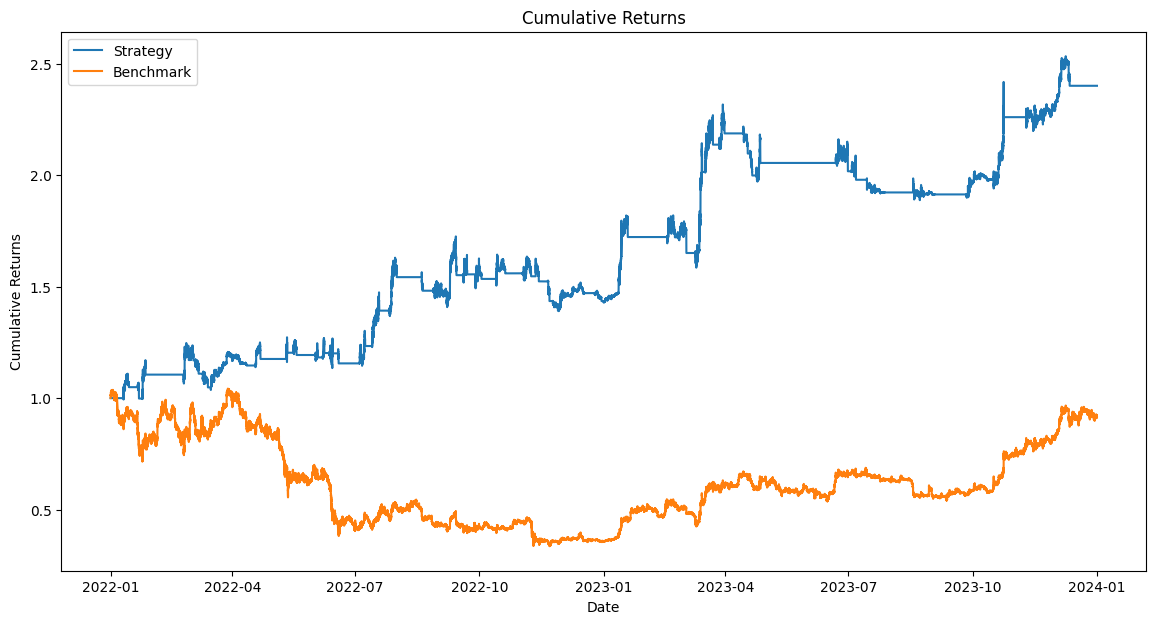

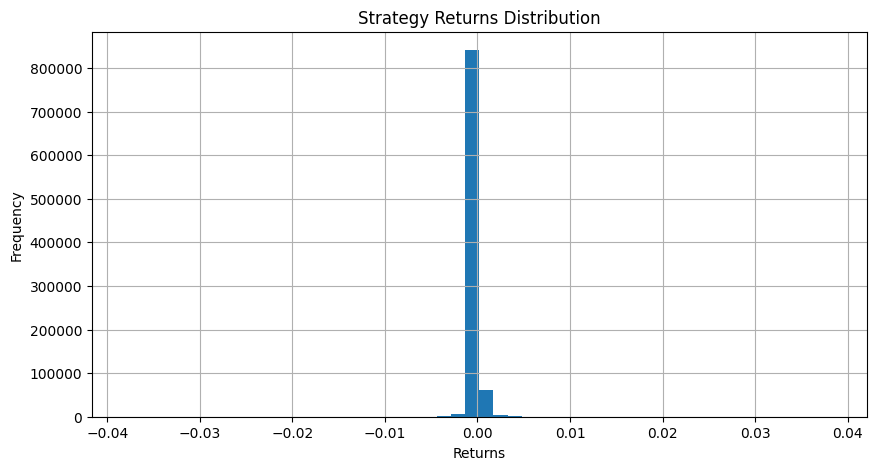

,Strategy,Benchmark
Metric,,
Total Return,140.08%,-8.63%
Annualized Return,54.99%,-4.41%
Number of Transactions,163,N/A
Average Gain/Loss per Transaction,"$86,381.47",N/A
Maximum Drawdown,-19.43%,-67.78%
Annualized Sharpe Ratio,1.76,0.18
Tracking Error,45.03%,N/A
Information Ratio,1.00,N/A
Treynor Ratio,1.68,N/A


In [53]:
strategy_params = {
    'buy_investment_amount': None,    # Invest $X per buy trade
    'sell_investment_amount': 2_500_000,   # Sell $X worth of BTC per sell trade
    'investment_fraction': 1.0,        # Alternatively, use fractions
    'use_limit_orders': True,            # Whether to use limit orders
    'buy_threshold': 0.655,                # Probability threshold to buy
    'sell_threshold': 0.31,               # Probability threshold to sell
    'limit_order_buffer': 0.00001,         # Price buffer for limit orders
    'limit_order_duration': 10,            # Duration in minutes to wait for limit order execution
    'stop_loss_pct' : 0.05,      # e.g., 0.10 for 10%
    'freeze_window' : 120         # Number of minutes to freeze trading after stop loss event
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[(trading_df.index >= '2022-01-01') & (trading_df.index < '2024-01-01')],
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


## We will now run our model OOS from the ML model and OOS from the hyperparameterization that we conducted, revealing its true performance.

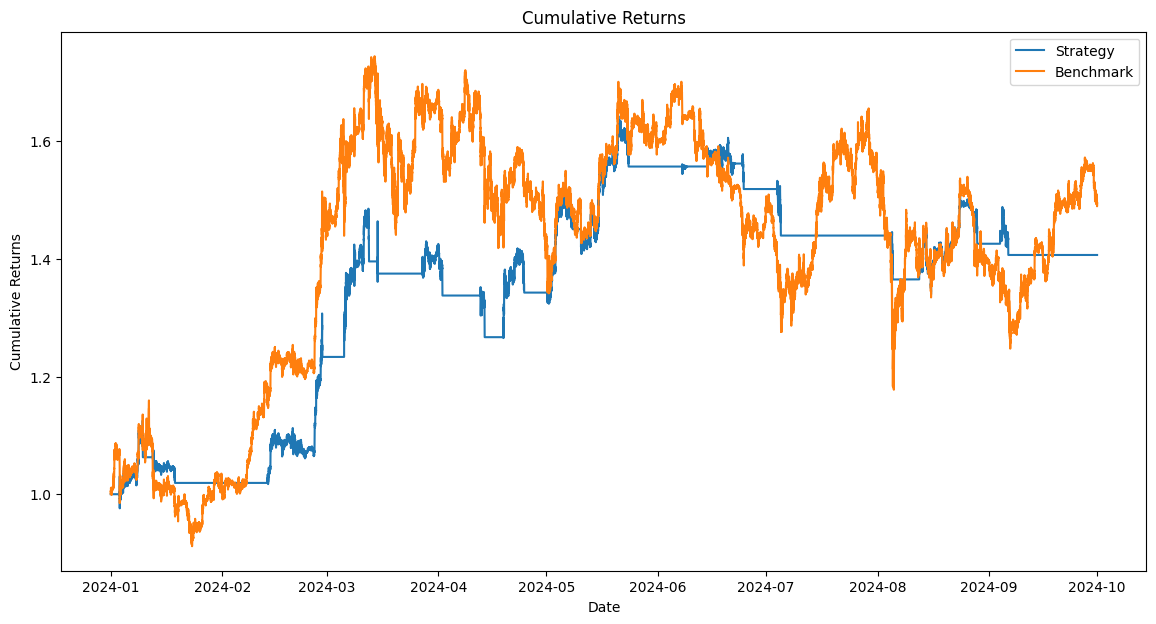

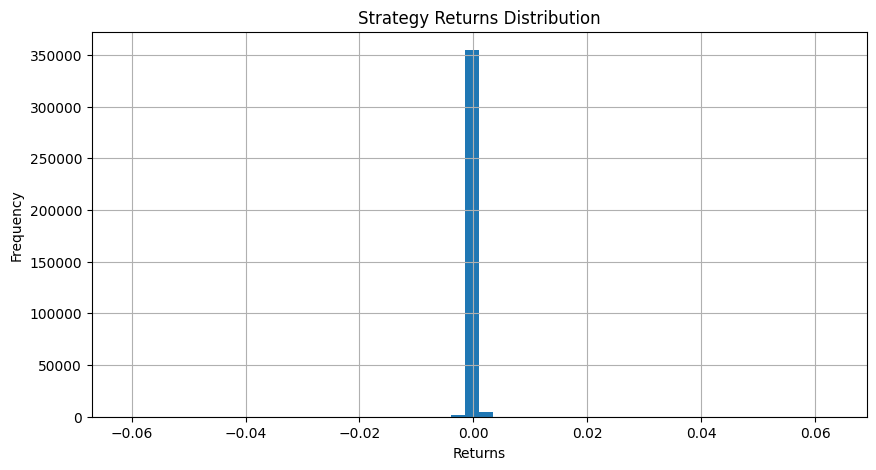

,Strategy,Benchmark
Metric,,
Total Return,40.68%,49.58%
Annualized Return,57.61%,71.04%
Number of Transactions,69,N/A
Average Gain/Loss per Transaction,"$59,669.51",N/A
Maximum Drawdown,-18.48%,-32.50%
Annualized Sharpe Ratio,1.83,1.43
Tracking Error,39.44%,N/A
Information Ratio,-0.43,N/A
Treynor Ratio,1.50,N/A


In [54]:
strategy_params = {
    'buy_investment_amount': None,    # Invest $X per buy trade
    'sell_investment_amount': 2_500_000,   # Sell $X worth of BTC per sell trade
    'investment_fraction': 1.0,        # Alternatively, use fractions
    'use_limit_orders': True,            # Whether to use limit orders
    'buy_threshold': 0.655,                # Probability threshold to buy
    'sell_threshold': 0.31,               # Probability threshold to sell
    'limit_order_buffer': 0.00001,         # Price buffer for limit orders
    'limit_order_duration': 10,            # Duration in minutes to wait for limit order execution
    'stop_loss_pct' : 0.05,      # e.g., 0.10 for 10%
    'freeze_window' : 120         # Number of minutes to freeze trading after stop loss event
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


In practice, one would likely retrain the ML model daily, and hyperparameterize the strategy using this model on the most recent (relevant) data. This would likely yield even more effective performance than that generated above, however due to computing constraints it is not something we have attempted.

Our strategy outperforms (Annualized Sharpe), and offers comparable returns with lower risk during periods in which the benchmark performs well. While we don't massively outperform in 2024 (a banner year for BTC), our true strength is seen in the first chart, from 2022-2023. This chart shows that we are able to massively outperform the BTC buy and hold benchmark during periods of underperformance, which is what our strategy was built to do. Overall we offer significantly improved performance both in up and down markets, but specifically in down markets, which is attractive for investors looking for BTC exposure, but without the full risk appetite that buying and holding BTC requires.

## We have included the full sample below for continuity purposes (the ML indicators are fully out of sample, and hyperparameterization is out of sample after Dec 2023)

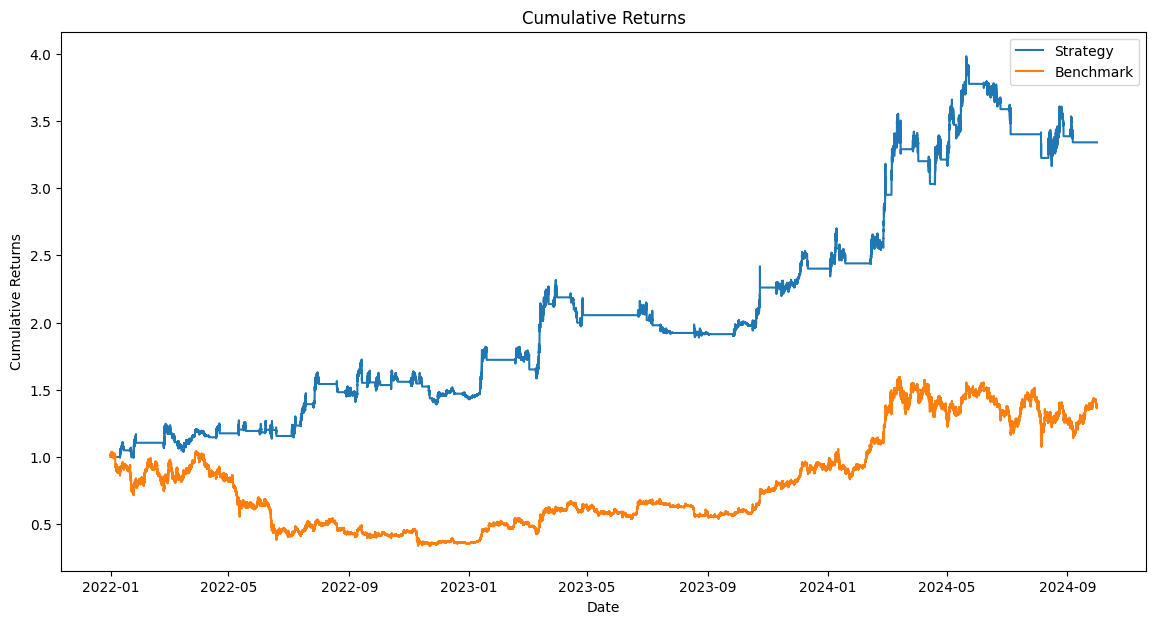

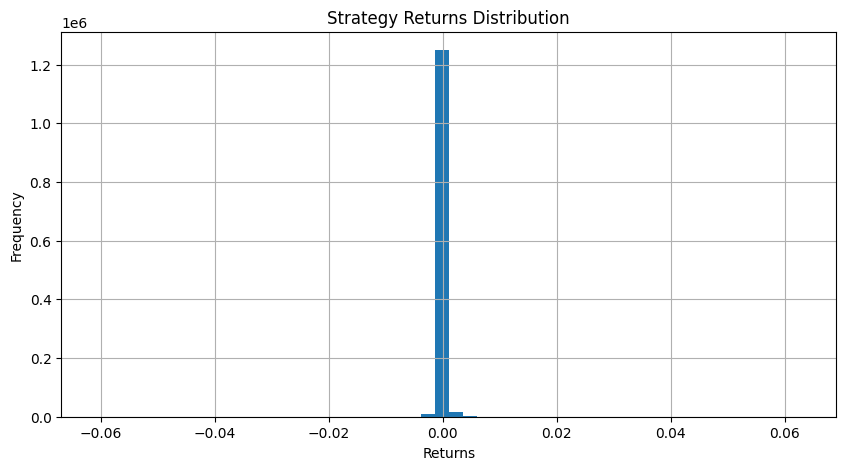

,Strategy,Benchmark
Metric,,
Total Return,234.03%,36.73%
Annualized Return,55.08%,12.05%
Number of Transactions,239,N/A
Average Gain/Loss per Transaction,"$98,271.99",N/A
Maximum Drawdown,-20.53%,-67.78%
Annualized Sharpe Ratio,1.76,0.51
Tracking Error,43.49%,N/A
Information Ratio,0.63,N/A
Treynor Ratio,1.61,N/A


In [55]:
strategy_params = {
    'buy_investment_amount': None,    # Invest $X per buy trade
    'sell_investment_amount': 2_500_000,   # Sell $X worth of BTC per sell trade
    'investment_fraction': 1.0,        # Alternatively, use fractions
    'use_limit_orders': True,            # Whether to use limit orders
    'buy_threshold': 0.655,                # Probability threshold to buy
    'sell_threshold': 0.31,               # Probability threshold to sell
    'limit_order_buffer': 0.00001,         # Price buffer for limit orders
    'limit_order_duration': 10,            # Duration in minutes to wait for limit order execution
    'stop_loss_pct' : 0.05,      # e.g., 0.10 for 10%
    'freeze_window' : 120         # Number of minutes to freeze trading after stop loss event
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2022-01-01'],
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df
